In [1]:
from __future__ import print_function
import os
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import string
import warnings

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
#from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing

import datetime as dt


# To identify the sentiment of text
#from textblob import TextBlob
#from textblob.sentiments import NaiveBayesAnalyzer
#from textblob.np_extractors import ConllExtractor

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-d

In [2]:
def download_file(file_url, folder_path, file_name):
    file_path = os.path.join(folder_path, file_name)
    if not os.path.exists(file_path):
        print('Downloading file from ' + file_url + '...')
        urlretrieve(file_url, file_path)
        print('Done downloading file: '+file_path)
    else:
        print('File: ' + file_path + ' already exists.')

In [3]:
def download_dataset():
    all_Tickets=pd.read_csv("D:\\IIM\\Project Final\\all_tickets.csv")
    return all_Tickets

In [4]:
all_ticket_df = download_dataset()

In [5]:
all_ticket_df['body'] = (all_ticket_df['title'] +   " " + all_ticket_df['body']).map(str)

In [6]:
def getRegexList():
    regexList = []
    regexList += ['From:(.*)\r\n']  # from line
    regexList += ['RITM[0-9]*'] # request id
    regexList += ['INC[0-9]*'] # incident id
    regexList += ['TKT[0-9]*'] # ticket id
    regexList += ['Sent:(.*)\r\n']  # sent to line
    regexList += ['Received:(.*)\r\n']  # received data line
    regexList += ['To:(.*)\r\n']  # to line
    regexList += ['CC:(.*)\r\n']  # cc line
    regexList += ['The information(.*)infection']  # footer
    regexList += ['The information in this email is confidential and may be legally(.*)interference if you are not the intended recipient']  # footer
    regexList += ['\[cid:(.*)]']  # images cid
    regexList += ['https?:[^\]\n\r]+']  # https & http
    regexList += ['Subject:']
    regexList += ['[\w\d\-\_\.]+@[\w\d\-\_\.]+']  # emails
    regexList += ['[0-9][\-0–90-9 ]+']  # phones
    regexList += ['[0-9]']  # numbers
    regexList += ['[^a-zA-z 0-9]+']  # anything that is not a letter
    regexList += ['[\r\n]']  # \r\n
    regexList += [' [a-zA-Z] ']  # single letters
    regexList += [' [a-zA-Z][a-zA-Z] ']  # two-letter words
    regexList += ["  "]  # double spaces
    regexList += ['^[_a-z0-9-]+(\.[_a-z0-9-]+)*@[a-z0-9-]+(\.[a-z0-9-]+)*(\.[a-z]{2,4})$']
    regexList += ['[\w\d\-\_\.]+ @ [\w\d\-\_\.]+']
    regexList += ['Subject:']
    regexList += ['[^a-zA-Z]']

    return regexList

def removeString(data, regex):
    return data.str.lower().str.replace(regex.lower(), ' ')

def datacleansing(all_ticket_df,getRegexList):
    # Removing URLs
    all_ticket_df['body'] = all_ticket_df['body'].apply(lambda x: re.sub(r"https\S+", "", str(x)))

    # Converting all tweets to lowercase¶
    all_ticket_df['body'] = all_ticket_df['body'].apply(lambda x: x.lower())

    #Carriage Returns & Tabs
    all_ticket_df['body'].replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=[" "," "], regex=True, inplace=True)

    #Special Characters
    spec_chars = ["!",'"',"#","%","&","'","(",")",
                "*","+",",","-",".","/",":",";","<",
                "=",">","?","@","[","\\","]","^","_",
                "`","{","|","}","~","–","-"]
    for char in spec_chars:
        all_ticket_df['body'] = all_ticket_df['body'].apply(lambda x:x.replace(char, ' '))

    #Extra spaces
    all_ticket_df['body'].replace('\s+', ' ', regex=True, inplace=True)

    #Remove non ASCII words
    all_ticket_df['body']=all_ticket_df['body'].apply(lambda x:x.encode("ascii","ignore").decode())
    
    #Removing StopWords
    nltk.download('stopwords')
    stop=set(stopwords)
    stop.update(['please', 'request', 'kindly', 'covid19', 'requesting'])
    all_ticket_df['body-tokenized']=all_ticket_df['body'].apply(lambda x: [item for item in x if item not in stop])

    # Create list of regex to remove sensitive data
    for regex in getRegexList:
        all_ticket_df['body'] = removeString(all_ticket_df['body'] , regex)
     

    # Remove empty strings and null rows after removing non english words
    all_ticket_df = all_ticket_df[all_ticket_df.body != " "]
    all_ticket_df = all_ticket_df[all_ticket_df.body != ""]
    all_ticket_df = all_ticket_df[~all_ticket_df.body.isnull()]
    all_ticket_df = all_ticket_df.dropna()
    return all_ticket_df



def encryptSingleColumn(data):
    le = preprocessing.LabelEncoder()
    le.fit(data)
    return le.transform(data)

def encryptColumnsCollection(data, columnsToEncrypt):
    for column in columnsToEncrypt:
        data[column] = encryptSingleColumn(data[column])
    return data

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
        
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training Accuracy')
    plt.plot(x, val_acc, 'r', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Model Loss')
    plt.legend()
    

In [8]:
all_ticket_df = datacleansing(all_ticket_df,getRegexList())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
all_ticket_df.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact,body-tokenized
1,connection with icon,connection with icon icon dear please setup ic...,1,6,22,7,26,3,4,"[c, n, n, e, c, n, , w, h, , c, n, , c, n, ..."
2,work experience user,work experience user work experience user work...,1,5,13,7,32,3,4,"[w, r, k, , e, x, p, e, r, e, n, c, e, , u, ..."
3,requesting for meeting,requesting for meeting requesting meeting plea...,1,5,13,7,32,3,4,"[r, e, q, u, e, n, g, , f, r, , e, e, n, g, ..."
4,reset passwords for external accounts,reset passwords for external accounts expire d...,1,4,2,76,4,3,4,"[r, e, e, , p, w, r, , f, r, , e, x, e, r, ..."
5,mail,mail verification warning has got attached ple...,1,4,3,7,89,3,4,"[l, , v, e, r, f, c, n, , w, r, n, n, g, , ..."


In [10]:

labelData = all_ticket_df['ticket_type']
data = all_ticket_df['body']
# Split dataset into training and testing data
train_data, test_data, train_labels, test_labels = train_test_split(
        data, labelData, test_size=0.2
    )  # split data to train/test sets with 80:20 ratio


In [11]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [12]:
# load the whole embedding into memory
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(train_data)
X_train = tokenizer.texts_to_sequences(train_data)
X_test = tokenizer.texts_to_sequences(test_data)
vocab_length = len(tokenizer.word_index) + 1

In [13]:
#from nltk.tokenize import word_tokenize
#corpus = all_ticket_df['body'].to_list()
#all_words = []
#for sent in corpus:
#    tokenize_word = word_tokenize(sent)
#    for word in tokenize_word:
#        all_words.append(word)

#unique_words = set(all_words)
#print(len(unique_words))
#vocab_length =len(unique_words)

In [14]:
corpus = all_ticket_df['body'].to_list()
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(corpus, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))


print(length_long_sentence)

911


In [15]:
#padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')
X_train_pedd = pad_sequences(X_train, length_long_sentence, padding='post')
X_test_pedd = pad_sequences(X_test, length_long_sentence, padding='post')

In [16]:
# define model
from keras import layers
from keras.optimizers import TFOptimizer
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_length, 
                           output_dim=embedding_dim, 
                           input_length=length_long_sentence,
                          trainable=True))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
#model.add(layers.Dense(1, activation='softmax'))

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 911, 100)          1158100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 91100)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                911010    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 2,069,121
Trainable params: 2,069,121
Non-trainable params: 0
_________________________________________________________________


In [17]:
# fit the model
#history = model.fit(padded_sentences, all_ticket_df['ticket_type'], epochs=100, verbose=1)
y_train = train_labels 
y_test = test_labels

history = model.fit(X_train_pedd, y_train,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_test_pedd, y_test), batch_size=10)


print(type(history))


C:\Users\Raj\anaconda3\envs\Py37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38269 samples, validate on 9568 samples
Epoch 1/5
38269/38269 [==============================] - 33s 867us/step - loss: 0.4040 - accuracy: 0.8299 - val_loss: 0.1119 - val_accuracy: 0.9744
Epoch 2/5
38269/38269 [==============================] - 33s 859us/step - loss: 0.0688 - accuracy: 0.9794 - val_loss: 0.0419 - val_accuracy: 0.9859
Epoch 3/5
38269/38269 [==============================] - 33s 866us/step - loss: 0.0385 - accuracy: 0.9876 - val_loss: 0.0308 - val_accuracy: 0.9885
Epoch 4/5
38269/38269 [==============================] - 33s 873us/step - loss: 0.0290 - accuracy: 0.9906 - val_loss: 0.0290 - val_accuracy: 0.9920
Epoch 5/5
38269/38269 [==============================] - 34s 890us/step - loss: 0.0239 - accuracy: 0.9920 - val_loss: 0.0236 - val_accuracy: 0.9918
<class 'keras.callbacks.callbacks.History'>


Training Accuracy: 99.4356
Testing Accuracy:  99.1848
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


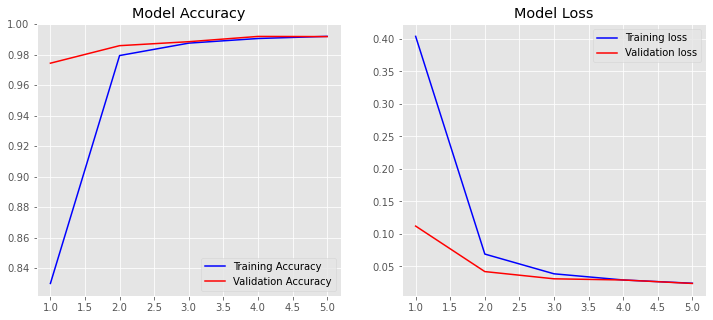

In [18]:
# evaluate the model
#loss, accuracy = model.evaluate(padded_sentences, all_ticket_df['ticket_type'], verbose=0)
#print('Accuracy: %f' % (accuracy*100))

loss, accuracy = model.evaluate(X_train_pedd, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy*100))

loss, accuracy = model.evaluate(X_test_pedd, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy*100))

print(history.history.keys())
plot_history(history)

In [19]:
#Predict

textd_1 ="hello movement has left available device please kind device denmark copenhagen denmark please source quotation shipping by lead"
textd_2 ="cannot submit hours getting error job defined for person assignment human resources application error"

testd =[textd_1,textd_2]
testd_tokens = tokenizer.texts_to_sequences(testd)
testd_tokens_pad = pad_sequences(testd_tokens, length_long_sentence, padding='post')

model.predict(x=testd_tokens_pad)

array([[0.98168486],
       [0.02986248]], dtype=float32)